### <u>Student Details</u>

### Student: Garret Molloy

### Student ID: 9021906

# Lab 5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

# Task 1

  * Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv and draw initial conclusions from the results you observe.


## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

### Load and prepare the dataset for training and evaluation
Feel free to apply any other pre-processing technique at this point.

In [2]:
lab5_df = pd.read_csv("./winequality_red.csv")
lab5_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


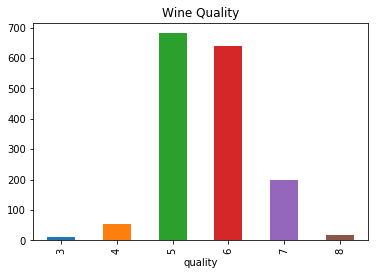

In [3]:
lab5_df['quality'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("quality")
plt.title("Wine Quality")
plt.show()

In [4]:
# target attribute
target_attribute_name = 'quality'
target = lab5_df[target_attribute_name]

# predictor attributes
predictors = lab5_df.drop(target_attribute_name, axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute is already binary
min_max_scaler = preprocessing.MinMaxScaler()

Split the data set into a training (80%) and test (20%) data sets.

In [5]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target)

In [6]:
predictors_train = min_max_scaler.fit_transform(predictors_train)
predictors_test = min_max_scaler.fit_transform(predictors_test)

## B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [7]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[6 1 9 4 2 8 3 5 7 1 1]


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [8]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression(solver='liblinear', multi_class='auto')
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[8 1 4 9 5 7 1 3 6 2 1]


## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [9]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [10]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [11]:
classifier = svm.SVC(gamma='auto')

In [12]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1_score = model1.score(predictors_test_SVMselected, target_test)

In [13]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2_score = model2.score(predictors_test_LRselected, target_test)

In [14]:
model3 = classifier.fit(predictors_train, target_train)
model3_score = model3.score(predictors_test, target_test)

In [15]:
print("  Model1 Score: %3.3f \t - features selected by SVM" %  model1_score)
print("  Model2 Score: %3.3f \t - features selected by SVM" %  model2_score)
print("* Model3 Score: %3.3f \t - features selected by SVM  ** Highest **" %  model3_score)

  Model1 Score: 0.547 	 - features selected by SVM
  Model2 Score: 0.547 	 - features selected by SVM
* Model3 Score: 0.556 	 - features selected by SVM  ** Highest **


### Task 1 Conclusion

After tresting the reduced features and the results using all features (model3) I got a better score fo all featutres, which is not what I expected. As it was hoped the reeduced feature set would preent over fitting and reduced noise for munnecessary attributes and correlated attributes.



<hr/>
<hr/>
<hr/>

## Task 2: Multiple Runs

- Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv but this time run the whole experiment in a loop with different training/test stratified splits. 
- Evaluate the three models for each iteration of the loop separately and boxplot the accuracies of the models for each iteration. 
- Compare the results of this experiment to the results of Task 1 in a markdown cell (max 150 words).

In [16]:
model1_scores = []
model2_scores = []
model3_scores = []

# I had more runs - but this computer would not return in time so I had to reduce
for lp in range(50):
    
    # pepare independent stratified data sets for training and test of the final model
    predictors_train, predictors_test, target_train, target_test = train_test_split(
            predictors, target, test_size=0.20, shuffle=True, stratify=target)
    
    estimatorSVM = svm.SVR(kernel="linear")
    selectorSVM = RFE(estimatorSVM, 3)
    selectorSVM = selectorSVM.fit(predictors_train, target_train)
    estimatorLR = LogisticRegression(solver='liblinear', multi_class='auto')
    selectorLR = RFE(estimatorLR, 3)
    selectorLR = selectorLR.fit(predictors_train, target_train)
    
    predictors_train_SVMselected = selectorSVM.transform(predictors_train)
    predictors_test_SVMselected = selectorSVM.transform(predictors_test)
    
    predictors_train_LRselected = selectorLR.transform(predictors_train)
    predictors_test_LRselected = selectorLR.transform(predictors_test)
    
    classifier = svm.SVC(kernel="linear", C=1, gamma='auto')
    
    model1 = classifier.fit(predictors_train_SVMselected, target_train)
    model1_scores.append(model1.score(predictors_test_SVMselected, target_test))
    
    model2 = classifier.fit(predictors_train_LRselected, target_train)
    model2_scores.append(model2.score(predictors_test_LRselected, target_test))

    model3 = classifier.fit(predictors_train, target_train)
    model3_scores.append(model3.score(predictors_test, target_test))
                         

In [17]:
scores = pd.DataFrame(data={'SVM Selected' : model1_scores, 
                            'LR Selected'  : model2_scores, 
                            'All Features' : model3_scores})

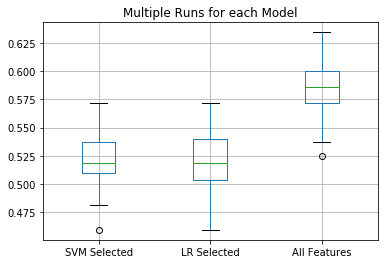

In [18]:
scores.boxplot()
plt.title("Multiple Runs for each Model")
plt.show()

In [19]:
print("  Model1 Original Score: %3.3f \t - features selected by SVM" %  model1_score)
print("  Model1 Average Score:  %3.3f \t - features selected by SVM Muliple Runs" %  np.mean(model1_scores))
print("  Model2 Original Score: %3.3f \t - features selected by SVM" %  model2_score)
print("* Model2 Average Score:  %3.3f \t - features selected by SVM Muliple Runs ** New Highest **" %  np.mean(model2_scores))
print("  Model3 Original Score: %3.3f \t - features selected by SVM" %  model3_score)
print("  Model3 Average Score:  %3.3f \t - features selected by SVM Muliple Runs" %  np.mean(model3_scores))


  Model1 Original Score: 0.547 	 - features selected by SVM
  Model1 Average Score:  0.522 	 - features selected by SVM Muliple Runs
  Model2 Original Score: 0.547 	 - features selected by SVM
* Model2 Average Score:  0.520 	 - features selected by SVM Muliple Runs ** New Highest **
  Model3 Original Score: 0.556 	 - features selected by SVM
  Model3 Average Score:  0.585 	 - features selected by SVM Muliple Runs


### Task 2 Conclusion

Originally model3 (All Features used) has the best scofre for a single run. 

Running through the experiment with all models multiple times and seeing the averages, I now see model2 has the best results, which used Logistic Regresion to select the features


<hr/>
<hr/>
<hr/>


## Task 3

Build __two__ pipelines for training classifiers for the dataset <i>winequality_red.csv</i> and 
__summarise the results__ from training classifiers with the pipelines. 

The two pipelines should include different __feature-selection__ methods.

## Pipeline 1

Design, Standard Scaling of the featutres followed with Recursive Feature Elimination (RFE).

In [20]:
X_train, X_test, y_train, y_test = train_test_split(predictors,target,test_size=0.2, random_state=30, stratify=target)

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# create feature union
feature_union = FeatureUnion(
    [
        ('rfe', RFE(svm.SVR(kernel="linear"), 3))
    ]
)

# create pipeline
model = Pipeline(
    [
        ('feature_union', feature_union),
        ('std_scaler', preprocessing.StandardScaler()),
        #("ET", ExtraTreesRegressor(random_state=42, n_estimators=250))
        #('svc',svm.SVC(kernel="linear", C=1, gamma='auto'))
        ('logistic_regression', LogisticRegression(solver='liblinear', multi_class='auto'))
    ]
)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X_train, y_train, cv=kfold)

print("Average Results from Pipeline", results.mean())

Average Results from Pipeline 0.5324311023622047


## Pipeline 2

Design, Standard Scaling of the features followed by an SVC estimator.
To improve training there is embedded 10 fold Cross Validaiton.

In [22]:
# create feature union
feature_union2 = FeatureUnion(
    [
        #('rfe', RFE(svm.SVR(kernel="linear"), 3))
        ('rfe', RFE(LogisticRegression(solver='liblinear', multi_class='auto'), 3))
    ]
)
model2 = Pipeline(
    [
        ('feature_union', feature_union2),
        ('scaler', StandardScaler()),
        ('svc',svm.SVC(kernel="rbf", C=1, gamma='auto'))
        #("ET", ExtraTreesRegressor(random_state=42, n_estimators=250))
    ]
)


# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results2 = cross_val_score(model2, X_train, y_train, cv=kfold)

print("Average Results from Pipeline", results.mean())

Average Results from Pipeline 0.5324311023622047


Using pipeline we glue together the StandardScaler() and SVC() and this ensure that during cross validation the StandardScaler is fitted to only the training fold, exactly similar fold used for SVC.fit()

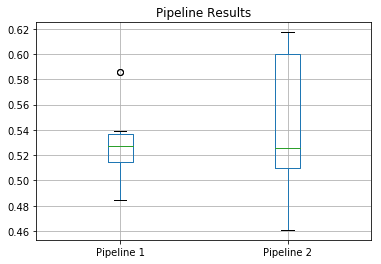

In [23]:
all_results = pd.DataFrame(data={'Pipeline 1' : results, 
                            'Pipeline 2'  : results2})
all_results.boxplot()
plt.title("Pipeline Results")
plt.show()

For this particular result we seea wider variation in results frmo pipeline2 but the average is about the same.